# Models a|b|bl

In [60]:
# %matplotlib inline
# %load_ext autotime

In [2]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [3]:
Session = 11
mouse = '3C290'

vis_mice = np.array(['nan', 'beta', 'alpha'])
# vis_mice = np.array(['nan', 'alpha', 'beta'])

active_blocks = [1,2,3,5,6]
# active_blocks = [1,2,4,5]


# active_blocks = [0,1,2]
# vis_mice = np.array(['alpha1', 'alpha2', 'alpha3'])
# vis_mice = np.array(['beta1', 'beta2', 'beta3'])

In [107]:
# a_idx=0
# b_idx=1
# bl_idx=2

In [4]:
a_idx = np.where(vis_mice=='alpha')[0][0]
b_idx = np.where(vis_mice=='beta')[0][0]

if len(active_blocks)>4:
    aa_idx=a_idx+4
    bb_idx=b_idx+4
    bl_idx=3
else:
    aa_idx=a_idx+3
    bb_idx=b_idx+3  

In [109]:
# create folder to save results
# os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models')

In [110]:
# cutoff = True
# cut=15

### Ephys data

In [5]:
KSdir = f"D:\\{mouse}_S{Session}\\Kilosort_2024-05-06_154258\\"

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [6]:
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = []
for clust in goodclusts :
    goods.append(clust)
print(f'Session {Session}: {len(goods)} good clusters')

Session 11: 40 good clusters


In [7]:
goodspiketimes = {}

spikethresh = 1000 # min nb of spikes
for goodunit in goods :
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : 
        goodspiketimes[goodunit] = spiketimes[goodinds]

### Behavior data

In [8]:
matfile = f"D:\\{mouse}_S{Session}\\Behaviour.mat"
EvaBehavior = loadmat(matfile)

In [9]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [10]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12) # 250 ms nosepokes onset|offset
VisitingSocialSamplingTriggers = load_behavioral_event(6) # all vis mouse npokes onset|offset
TestSocialSamplingTriggers = load_behavioral_event(7) # all test mouse npokes onset|offset (not only 250 ms)

TestSocialSampleOnsetPerTrial = load_behavioral_event(10)
TestSocialSampleOffsetPerTrial = load_behavioral_event(11)

## Data prep: firing rate array

In [13]:
def fr_matrix_prep(beforesamples, aftersamples, blocks, bins, units=goodspiketimes.keys()):
    fr_dic = {}
   
    for block in blocks:
        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]
        n_units = len(goodspiketimes.keys())

        fr_matrix = np.zeros((n_trials, n_units))

        i = 0
        for unit in units: # list of good cluster_id
            
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes = goodspiketimes[unit][np.intersect1d(cond1,cond2)].astype(int)-onset

                n = np.histogram(unitspikes, bins=bins)[0][0]
                fr = n/0.25
                fr_matrix[event, i] = fr
            i+=1
                
        fr_dic[block] = fr_matrix
    
    return fr_dic
        

### Firing rates

firing rate [Hz] = spike_count/ time_window(sec)

* lets find it for each trial for each cell
* we will make an array where each row is trial; each column - neuron; we will collect it in dict where keys = blocks

In [14]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 0*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 0*samplplimg_rate # 1 sec
npoke_window = 0.25
eventlength = npoke_window*samplplimg_rate # 0.25 s


# for psth
binsize = 0.25*samplplimg_rate ### 50 ms 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

In [15]:
# 250 ms during the nosepoke
fr_dic = fr_matrix_prep(beforesamples, aftersamples, blocks=active_blocks, bins=bins)

In [18]:
fr_dic[5].shape # raws - trials; col - neurons

(10, 38)

In [17]:
fr_dic[2]

array([[ 0.,  0.,  0., ..., 20.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  0.,  0.],
       [ 0.,  0.,  0., ..., 32.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 40.,  0.,  4.],
       [ 0.,  0.,  0., ..., 36.,  0.,  4.],
       [ 0.,  0.,  0., ..., 20.,  0.,  0.]])

## Classifiers

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from scipy.stats import percentileofscore

In [41]:
# if cutoff:
#     if len(firing_rates_dic[aa_idx])>len(firing_rates_dic[bb_idx]):
#         firing_rates_dic[aa_idx] = firing_rates_dic[aa_idx][:cut,:]
#     else:
#         firing_rates_dic[bb_idx] = firing_rates_dic[bb_idx][:cut,:]
#     print(firing_rates_dic[aa_idx].shape,firing_rates_dic[bb_idx].shape)

(15, 33) (15, 33)


In [20]:
# keys = ['evening_cv', 'day_cv', 'morning_cv', 'social_blank']
keys = ['morning_cv_12', 'morning_cv_13','morning_cv_23']
classifiers_results = {key: None for key in keys}

### Evening cv

Train blocks12; test blocks 34

#### SVM

In [22]:
firing_rates_dic.keys()

dict_keys([1, 2, 3, 5, 6])

In [24]:
a_idx, b_idx, aa_idx, bb_idx

(1, 2, 5, 6)

In [33]:
X_train = np.concatenate((firing_rates_dic[a_idx],firing_rates_dic[b_idx]), axis=0)
X_test = np.concatenate((firing_rates_dic[aa_idx],firing_rates_dic[bb_idx]), axis=0)

y_train = np.concatenate((np.ones(firing_rates_dic[a_idx].shape[0]),np.zeros(firing_rates_dic[a_idx].shape[0])))
y_test = np.concatenate((np.ones(firing_rates_dic[aa_idx].shape[0]),np.zeros(firing_rates_dic[aa_idx].shape[0])))

# randomize train
num_rows = X_train.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((60, 33), (60,), (30, 33), (30,))

In [35]:
SVMs = {}

for kernel in ['linear', 'poly', 'rbf']:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    # real model
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred)
    SVM_results['accuracy'] = accuracy_svm

    # shuffle test
    accuracy_test_shuffle = []
    for shuffle in range(1000):
        # shuffle trials in the matrix
        num_rows = X_test.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl = X_test[shuffled_indices]
        accuracy_test_shuffle.append(accuracy_score(y_test, svm_classifier.predict(Xctrl)))
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle

    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, accuracy_svm)
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value

    # shuffle all
    accuracy_all_shuffle = []
    for shuffle in range(1000):
        ## shuffle train
        num_rows = X_train.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl_train = X_train[shuffled_indices]
        random.shuffle(shuffled_indices)
        yctrl_train = y_train[shuffled_indices]

        ## shuffle test
        num_rows = X_test.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl = X_test[shuffled_indices]
        random.shuffle(shuffled_indices)
        yctrl = y_test[shuffled_indices]

        svm_classifier_ctrl_all = SVC(kernel=kernel)
        svm_classifier_ctrl_all.fit(Xctrl_train, yctrl_train)
        accuracy_all_shuffle.append(accuracy_score(yctrl, svm_classifier_ctrl_all.predict(Xctrl)))
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle

    ## shuffle all stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, accuracy_svm)
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    # shuffle train
    accuracy_train_shuffle = []

    for shuffle in range(1000):
        ## shuffle train
        num_rows = X_train.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        Xctrl_train = X_train[shuffled_indices]
        random.shuffle(shuffled_indices)
        yctrl_train = y_train[shuffled_indices]

        svm_classifier_ctrl_train = SVC(kernel=kernel)
        svm_classifier_ctrl_train.fit(Xctrl_train, yctrl_train)
        accuracy_train_shuffle.append(accuracy_score(y_test, svm_classifier_ctrl_train.predict(X_test)))
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle

    ## shuffle all stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, accuracy_svm)
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results


classifiers_results['evening_cv'] = SVMs


In [36]:
SVMs[kernel]['accuracy']

0.5

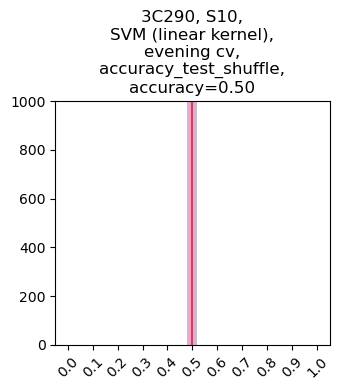

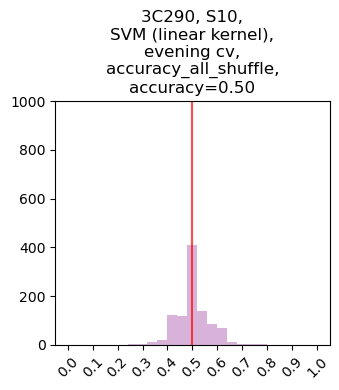

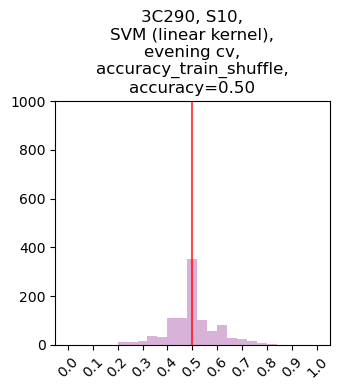

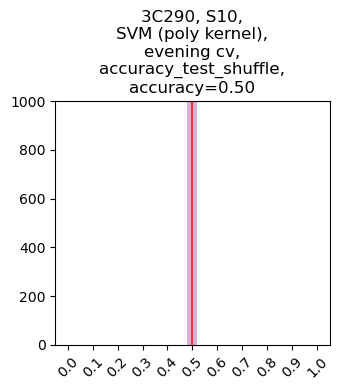

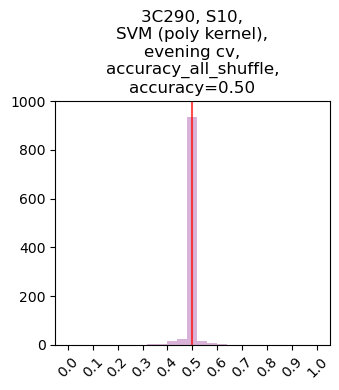

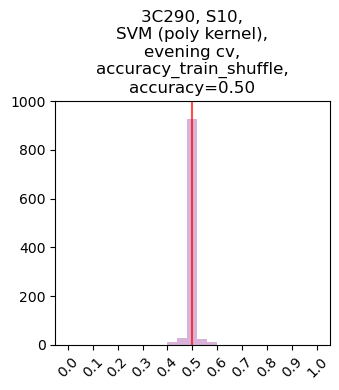

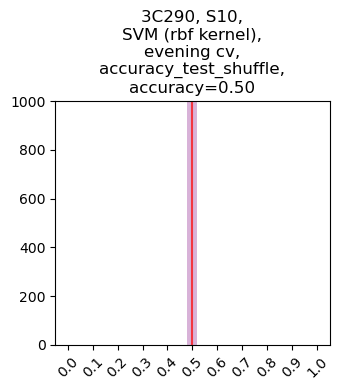

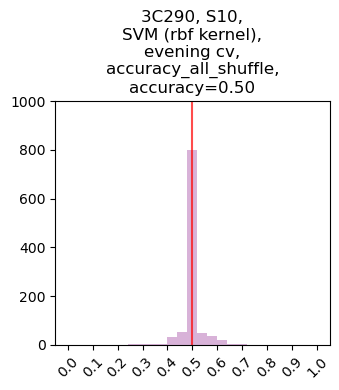

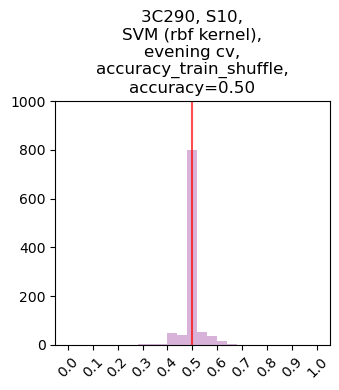

In [37]:
# Plot data
for kernel in ['linear', 'poly', 'rbf']:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,4)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.3, color='purple')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a = SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nevening cv,\n{shuffle},\naccuracy={a:.2f}')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,1000)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models\\{mouse}_S{Session}_SVM{kernel}_eveningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

##### Bayes

In [38]:
bayes = {}

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

# real model
bayes_classifier = GaussianNB()
bayes_classifier.fit(X_train, y_train)
y_pred = bayes_classifier.predict(X_test)
accuracy_bayes = accuracy_score(y_test, y_pred)
bayes_results['accuracy'] = accuracy_bayes

# shuffle test
accuracy_test_shuffle = []
for shuffle in range(1000):
    # shuffle trials in the matrix
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]
    accuracy_test_shuffle.append(accuracy_score(y_test, bayes_classifier.predict(Xctrl)))
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, accuracy_bayes)
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value

# shuffle all
accuracy_all_shuffle = []
for shuffle in range(1000):
    ## shuffle train
    num_rows = X_train.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl_train = X_train[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl_train = y_train[shuffled_indices]

    ## shuffle test
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl = y_test[shuffled_indices]

    bayes_classifier_ctrl_all = GaussianNB()
    bayes_classifier_ctrl_all.fit(Xctrl_train, yctrl_train)
    accuracy_all_shuffle.append(accuracy_score(yctrl, bayes_classifier_ctrl_all.predict(Xctrl)))
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle

## shuffle all stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, accuracy_bayes)
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

# shuffle train
accuracy_train_shuffle = []

for shuffle in range(1000):
    ## shuffle train
    num_rows = X_train.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl_train = X_train[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl_train = y_train[shuffled_indices]

    bayes_classifier_ctrl_train = GaussianNB()
    bayes_classifier_ctrl_train.fit(Xctrl_train, yctrl_train)
    accuracy_train_shuffle.append(accuracy_score(y_test, bayes_classifier_ctrl_train.predict(X_test)))
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle all stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, accuracy_bayes)
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value

classifiers_results['evening_cv']['bayes'] = bayes_results

In [39]:
classifiers_results['evening_cv'].keys()

dict_keys(['linear', 'poly', 'rbf', 'bayes'])

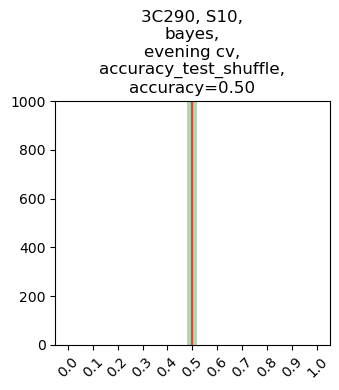

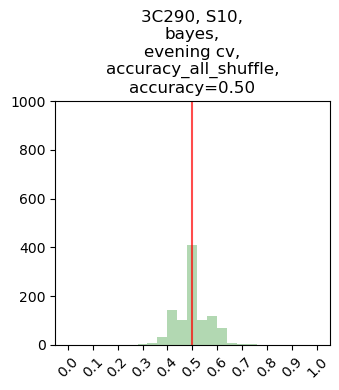

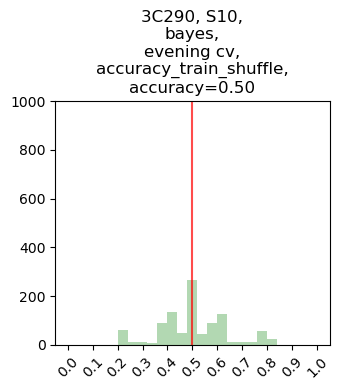

In [40]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,4)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.3, color='green')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a =bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nevening cv,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,1000)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models\\{mouse}_S{Session}_bayes_eveningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Day cv

Cross-validation on all dataset

#### SVM

In [42]:
alpha_data = np.concatenate((firing_rates_dic[a_idx],firing_rates_dic[aa_idx]), axis=0)
beta_data = np.concatenate((firing_rates_dic[b_idx],firing_rates_dic[bb_idx]), axis=0)

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [43]:
alpha_data.shape, beta_data.shape

((45, 33), (45, 33))

In [44]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

SVMs = {}

for kernel in ['linear', 'poly', 'rbf']:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    accuracy_cv5 = []
    accuracy_test_shuffle = []
    accuracy_all_shuffle = []
    accuracy_train_shuffle = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred))

        # shuffle test
        for shuffle in range(1000):
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

        # all shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            # shuffle outcomes
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

        # train shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab)
            accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))
    # save results
    SVM_results['accuracy'] = np.mean(accuracy_cv5)
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle


    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value   

    ## shuffle test stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    ## shuffle test stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results

classifiers_results['day_cv'] = SVMs

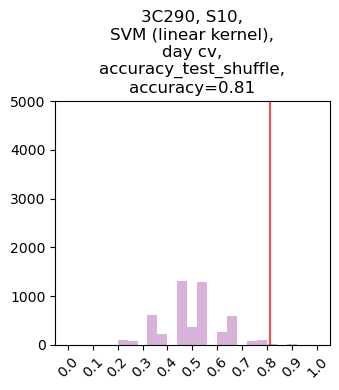

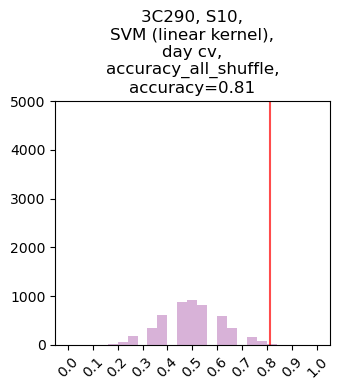

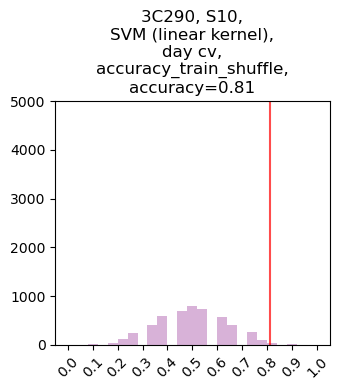

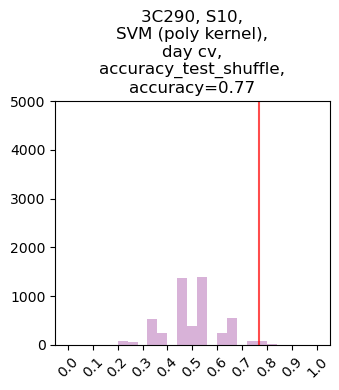

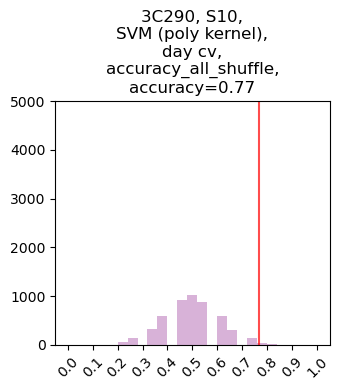

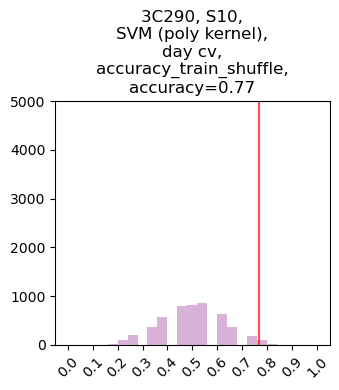

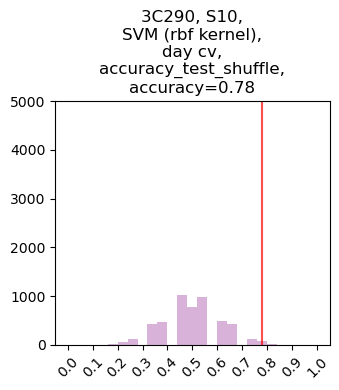

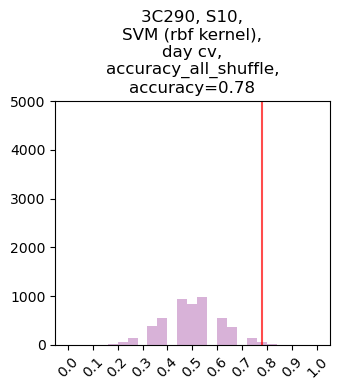

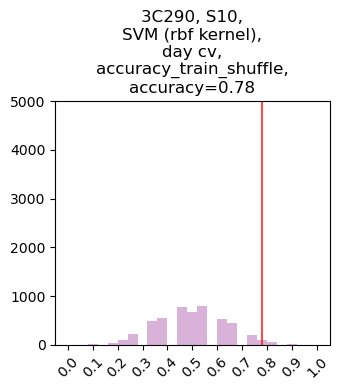

In [45]:
# Plot data
for kernel in ['linear', 'poly', 'rbf']:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,4)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.3, color='purple')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a=SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nday cv,\n{shuffle},\naccuracy={a:.2f}')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,5000)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_SVM{kernel}_daycv_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

#### Bayes

In [47]:
# data prep
alpha_data = np.concatenate((firing_rates_dic[a_idx],firing_rates_dic[aa_idx]), axis=0)
beta_data = np.concatenate((firing_rates_dic[b_idx],firing_rates_dic[bb_idx]), axis=0)

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [48]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

bayes = {}

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

accuracy_cv5 = []
accuracy_test_shuffle = []
accuracy_all_shuffle = []
accuracy_train_shuffle = []

for n in range(cv):

    # data prep
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    # dataset
    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)
    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    # actual prediction
    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # test shuffle
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

    # all shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

    # train shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab)
        accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))

# save results
bayes_results['accuracy'] = np.mean(accuracy_cv5)
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value   

## shuffle test stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

## shuffle test stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value

classifiers_results['day_cv']['bayes'] = bayes_results

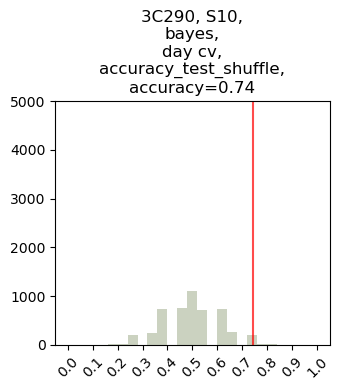

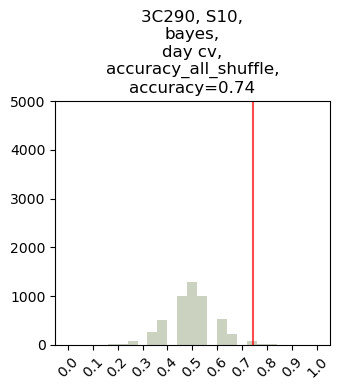

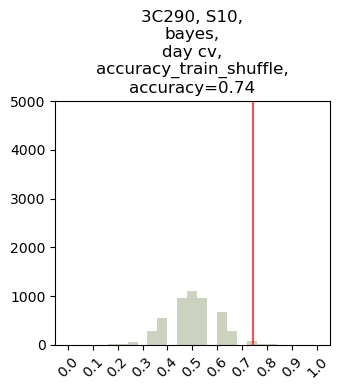

In [49]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,4)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.3, color='#556B2F')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a=bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nday cv,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,5000)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_bayes_daycv_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Morning cv

In [21]:
# data prep
alpha_data = fr_dic[a_idx]
beta_data = fr_dic[b_idx]

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [22]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

In [212]:
# alpha_data.shape, beta_data.shape

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

for n in range(cv):
    # data prep
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    # Initialize the grid search
    grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit the grid search
    grid_search.fit(train_ab, y_train)

    # Evaluate the results
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(test_ab)
    print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
    print('=================================================================================================================')
    print()

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Best cross-validation score: 0.9777777777777779
Test set accuracy: 0.9166666666666666

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.8977777777777778
Test set accuracy: 1.0

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.9177777777777777
Test set accuracy: 1.0

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.96
Test set accuracy: 1.0

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.9355555555555555
Test set accuracy: 1.0



In [27]:
# ['linear', 'poly', 'rbf']
kernels = ['linear', 'rbf']

In [28]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

SVMs = {}

for kernel in kernels:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    accuracy_cv5 = []
    accuracy_test_shuffle = []
    accuracy_all_shuffle = []
    accuracy_train_shuffle = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred))

        # shuffle test
        for shuffle in range(1000):
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

        # all shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            # shuffle outcomes
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

        # train shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab)
            accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))
    # save results
    SVM_results['accuracy'] = np.mean(accuracy_cv5)
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle


    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value   

    ## shuffle test stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    ## shuffle test stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results

classifiers_results['morning_cv'] = SVMs


In [30]:
for kernel in kernels:
    print(kernel)
    for shuffle in ['pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']:
        print(shuffle, SVMs[kernel][shuffle])
    print('=====================================================================')
    print()

linear
pval_test_shuffle 0.0008000000000000229
pval_all_shuffle 0.0006000000000000449
pval_train_shuffle 0.0

rbf
pval_test_shuffle 0.0
pval_all_shuffle 0.0
pval_train_shuffle 0.007399999999999962



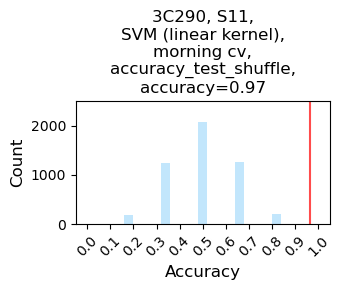

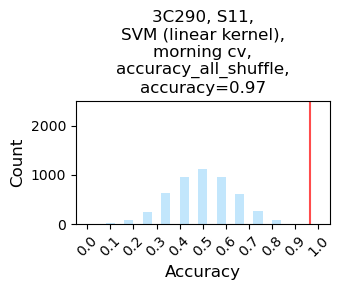

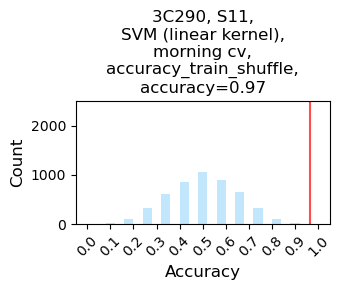

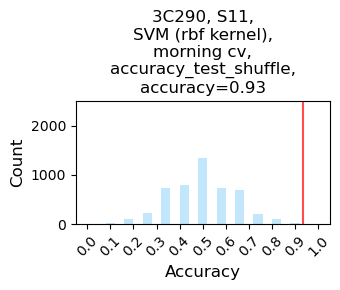

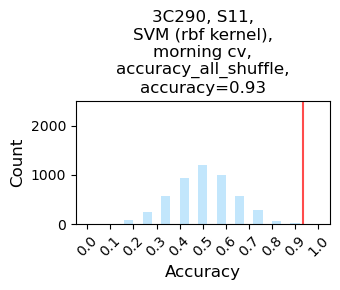

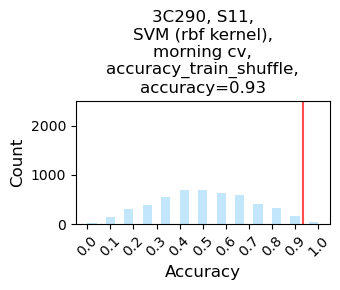

In [34]:
# Plot data
for kernel in kernels:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,3)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.5, color='#87CEFA')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a=SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nmorning cv,\n{shuffle},\naccuracy={a:.2f}')
        plt.xlabel('Accuracy', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,2500)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models\\{mouse}_S{Session}_SVM{kernel}_morningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

#### Bayes

In scikit-learn, there are several types of Naive Bayes classifiers, each suited for different types of data:

- **Gaussian Naive Bayes (GaussianNB):** Suitable for continuous data that follows a normal (Gaussian) distribution.
- **Multinomial Naive Bayes (MultinomialNB):** Suitable for discrete data (e.g., counts of occurrences in text classification).
- **Bernoulli Naive Bayes (BernoulliNB):** Suitable for binary/boolean data.
- **Complement Naive Bayes (ComplementNB):** Designed to handle imbalanced datasets, particularly in text classification.
- **Categorical Naive Bayes (CategoricalNB):** Suitable for categorical features (new in scikit-learn 0.24).


Choosing the Right Naive Bayes Classifier:

- **GaussianNB**: Use this if your features are continuous and you assume they follow a Gaussian distribution.
- **MultinomialNB**: Use this if your features are counts or frequencies (e.g., term frequencies in text data).
- **BernoulliNB**: Use this if your features are binary (0 or 1).
- **ComplementNB**: Use this if you have an imbalanced dataset, especially in text classification.
- Catego**ricalNB: Use this if your features are categorical.


---> we will use **GaussianNB**

---> # There are no hyperparameters for GaussianNB to tune with GridSearchCV

In [35]:
# data prep
alpha_data = fr_dic[a_idx]
beta_data = fr_dic[b_idx]

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [36]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

accuracy_cv5 = []
accuracy_test_shuffle = []
accuracy_all_shuffle = []
accuracy_train_shuffle = []

for n in range(cv):

    # data prep
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    # dataset
    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)
    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    # actual prediction
    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # test shuffle
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

    # all shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

    # train shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab)
        accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))

# save results
bayes_results['accuracy'] = np.mean(accuracy_cv5)
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value   

## shuffle test stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

## shuffle test stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value


classifiers_results['morning_cv']['bayes'] = bayes_results


In [43]:
for shuffle in ['pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']:
    print(shuffle, bayes_results[shuffle])
print('=====================================================================')
print()

pval_test_shuffle 0.03920000000000001
pval_all_shuffle 0.02980000000000005
pval_train_shuffle 0.05940000000000001



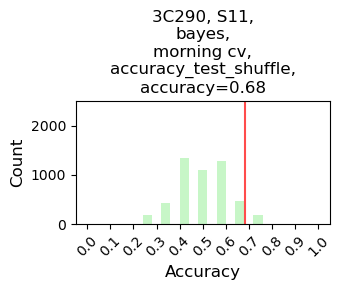

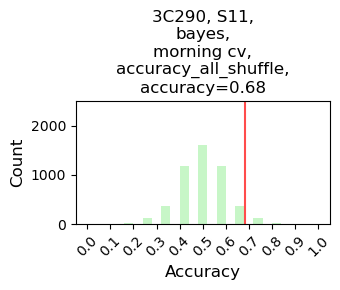

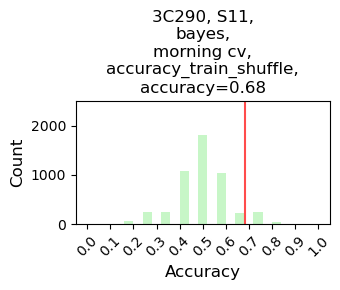

In [46]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,3)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.5, color='#90EE90')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a=bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nmorning cv,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,2500)
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_bayes_morningcv_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Morning control! mono mouse session

a/a/a or b/b/b sesions

In [83]:
def data_prep(a,b):
    alpha_data = firing_rates_dic[a]
    beta_data = firing_rates_dic[b]

    # randomize morning/evening
    num_rows = alpha_data.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    alpha_data = alpha_data[shuffled_indices]
    random.shuffle(shuffled_indices)
    beta_data = beta_data[shuffled_indices]

    return alpha_data, beta_data

In [98]:
alpha_data, beta_data = data_prep(b_idx,bl_idx)
dickey = 'morning_cv_23'

In [99]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

SVMs = {}

for kernel in ['linear', 'poly', 'rbf']:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    accuracy_cv5 = []
    accuracy_test_shuffle = []
    accuracy_all_shuffle = []
    accuracy_train_shuffle = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred))

        # shuffle test
        for shuffle in range(1000):
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

        # all shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            # shuffle outcomes
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

        # train shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab)
            accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))
    # save results
    SVM_results['accuracy'] = np.mean(accuracy_cv5)
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle


    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value   

    ## shuffle test stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    ## shuffle test stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results

classifiers_results[dickey] = SVMs


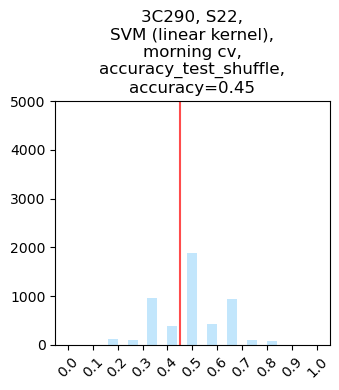

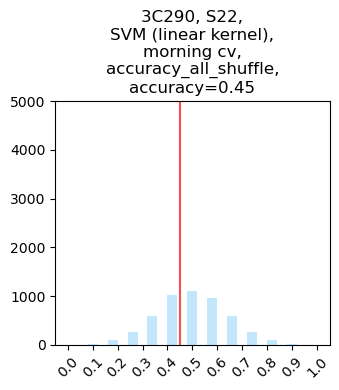

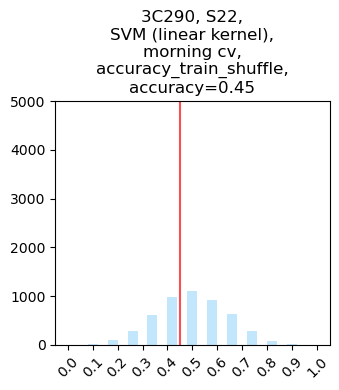

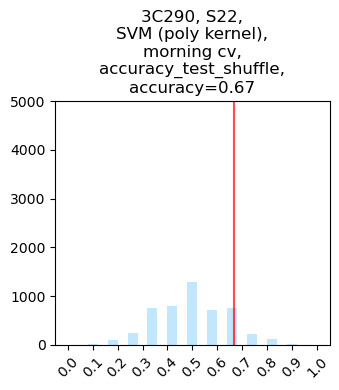

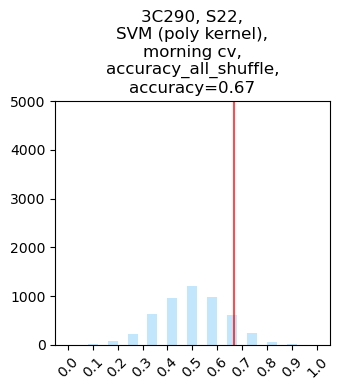

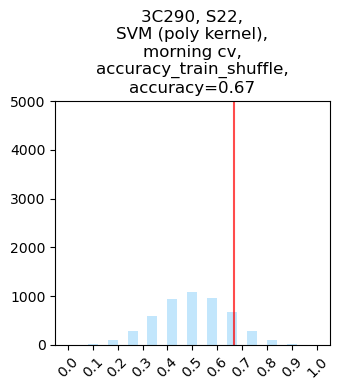

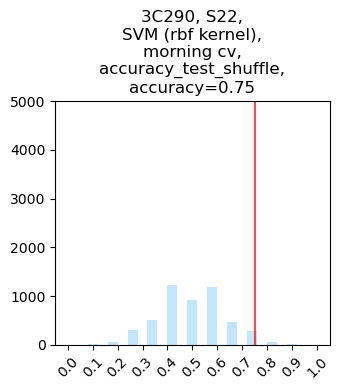

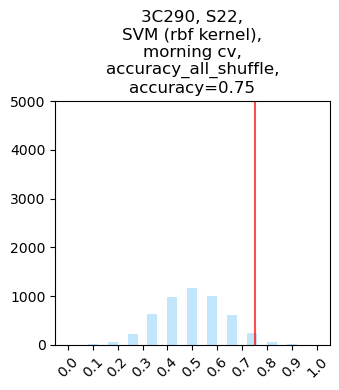

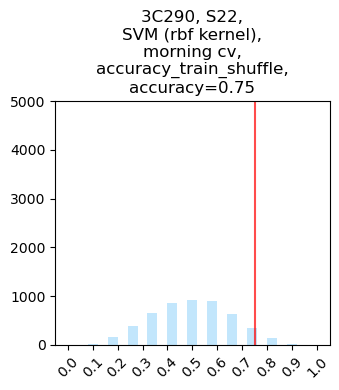

In [100]:
# Plot data
for kernel in ['linear', 'poly', 'rbf']:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,4)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.5, color='#87CEFA')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a=SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nmorning cv,\n{shuffle},\naccuracy={a:.2f}')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,5000)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_SVM{kernel}_{dickey}_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

#### Bayes

In [101]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

bayes = {}

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

accuracy_cv5 = []
accuracy_test_shuffle = []
accuracy_all_shuffle = []
accuracy_train_shuffle = []

for n in range(cv):

    # data prep
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    # dataset
    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)
    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    # actual prediction
    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # test shuffle
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

    # all shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

    # train shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab)
        accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))

# save results
bayes_results['accuracy'] = np.mean(accuracy_cv5)
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value   

## shuffle test stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

## shuffle test stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value


classifiers_results[dickey]['bayes'] = bayes_results


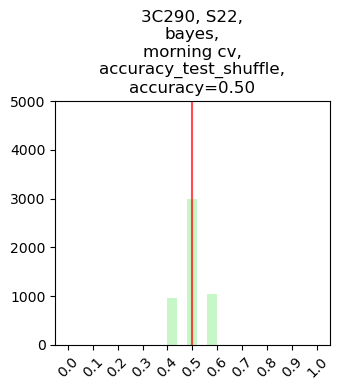

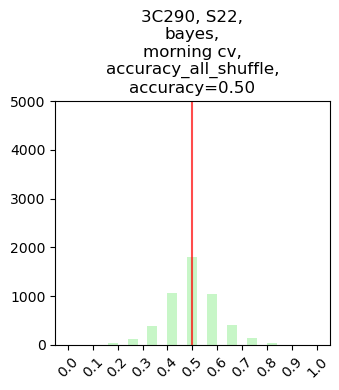

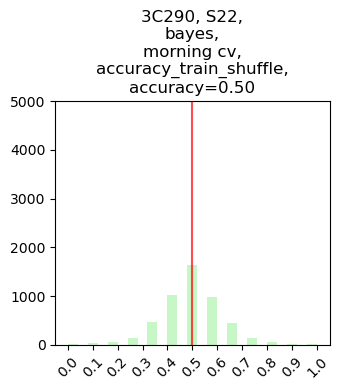

In [102]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,4)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.5, color='#90EE90')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a=bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nmorning cv,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,5000)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_bayes_{dickey}_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [103]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models\\{mouse}_S{Session}_classifiers_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(classifiers_results, f)

In [104]:
print(f'Session {Session}')
for cv in ['morning_cv_12', 'morning_cv_13','morning_cv_23']:
    print(cv)
    print()
    for model in ['linear', 'poly', 'rbf', 'bayes']:

        print(model)
        print(round(classifiers_results[cv][model]['accuracy'], 3))
        print()
        print(round(classifiers_results[cv][model]['pval_all_shuffle'], 3))
        print(round(classifiers_results[cv][model]['pval_train_shuffle'], 3))
        print(round(classifiers_results[cv][model]['pval_test_shuffle'], 3))
        print()
    print('---------------------------------------')
    print()

Session 22
morning_cv_12

linear
0.75

0.045
0.058
0.051

poly
0.85

0.002
0.006
0.006

rbf
0.783

0.014
0.065
0.03

bayes
0.633

0.172
0.174
0.196

---------------------------------------

morning_cv_13

linear
0.683

0.068
0.108
0.048

poly
0.867

0.002
0.02
0.008

rbf
0.75

0.069
0.137
0.054

bayes
0.567

0.351
0.351
0.246

---------------------------------------

morning_cv_23

linear
0.45

0.604
0.603
0.688

poly
0.667

0.065
0.075
0.069

rbf
0.75

0.039
0.063
0.042

bayes
0.5

0.504
0.491
0.507

---------------------------------------



## Social vs blank (morning)

social = 1
blank = 0

In [47]:
# data prep
alpha_data = fr_dic[a_idx]
beta_data = fr_dic[b_idx]
blank_data = fr_dic[3]

# randomize
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]
random.shuffle(shuffled_indices)
blank_data = blank_data[shuffled_indices]

# alpha-beta joined set
social_data = np.concatenate((alpha_data[:int(num_rows/2),:], beta_data[int(num_rows/2):,:]), axis=0)
random.shuffle(shuffled_indices)
social_data = social_data[shuffled_indices]

In [219]:
'social_blank'

'social_blank'

In [48]:
blank_data.shape, social_data.shape

((30, 38), (30, 38))

In [49]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

SVMs = {}

for kernel in ['linear']:

    # collect outcomes
    svm_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
    SVM_results = {key: None for key in svm_keys}

    accuracy_cv5 = []
    accuracy_test_shuffle = []
    accuracy_all_shuffle = []
    accuracy_train_shuffle = []

    for n in range(cv):
        test_social_idx = random.sample(indices, train_proportion)
        train_social_idx = [number for number in indices if number not in test_social_idx]
        test_social = social_data[test_social_idx]
        train_social = social_data[train_social_idx]

        test_blank_idx = random.sample(indices, train_proportion)
        train_blank_idx = [number for number in indices if number not in test_blank_idx]
        test_blank = blank_data[test_blank_idx]
        train_blank = blank_data[train_blank_idx]

        test_ab = np.concatenate((test_social,test_blank), axis=0)
        train_ab = np.concatenate((train_social,train_blank), axis=0)

        y_test = np.concatenate((np.ones(test_social.shape[0]),np.zeros(test_blank.shape[0])))
        y_train = np.concatenate((np.ones(train_social.shape[0]),np.zeros(train_blank.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred))

        # shuffle test
        for shuffle in range(1000):
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

        # all shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            # shuffle outcomes
            num_rows = test_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            test_ab_ctrl = test_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab_ctrl)
            accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

        # train shuffle
        for shuffle in range(1000):
            # shuffle train
            num_rows = train_ab.shape[0]
            shuffled_indices = list(range(num_rows))
            random.shuffle(shuffled_indices)
            train_ab_ctrl = train_ab[shuffled_indices]

            svm_classifier_cv = SVC(kernel=kernel)
            svm_classifier_cv.fit(train_ab_ctrl, y_train)
            y_pred = svm_classifier_cv.predict(test_ab)
            accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))
    # save results
    SVM_results['accuracy'] = np.mean(accuracy_cv5)
    SVM_results['accuracy_test_shuffle'] = accuracy_test_shuffle
    SVM_results['accuracy_all_shuffle'] = accuracy_all_shuffle
    SVM_results['accuracy_train_shuffle'] = accuracy_train_shuffle


    ## shuffle test stats
    accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
    percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_test_shuffle'] = p_value   

    ## shuffle test stats
    accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
    percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_all_shuffle'] = p_value

    ## shuffle test stats
    accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
    percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
    # one-tailored
    p_value = 1-(percentile_rank/100)
    SVM_results['pval_train_shuffle'] = p_value

    SVMs[kernel] = SVM_results

classifiers_results['social_blank'] = SVMs

In [51]:
for kernel in ['linear']:
    print(kernel)
    for shuffle in ['pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']:
        print(shuffle, SVMs[kernel][shuffle])
    print('=====================================================================')
    print()

linear
pval_test_shuffle 0.0015999999999999348
pval_all_shuffle 0.0031999999999999806
pval_train_shuffle 0.0048000000000000265



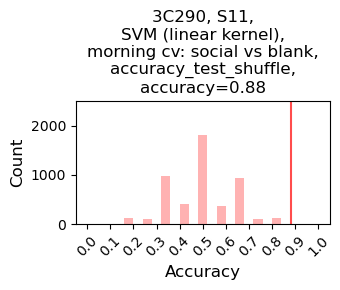

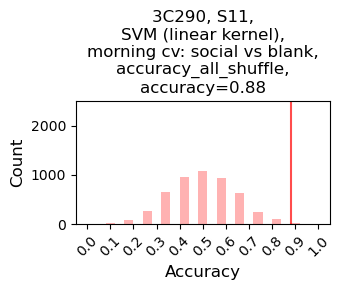

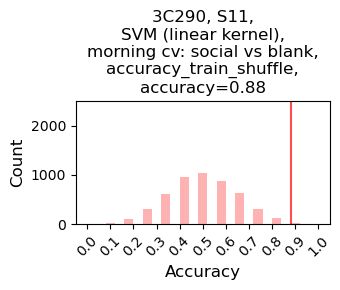

In [52]:
# Plot data
for kernel in ['linear']:
    for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
        plt.figure(figsize=(3.5,3)) 
        bin_edges = np.arange(0, 1+0.04, 0.04)
        plt.hist(SVMs[kernel][shuffle], bins=bin_edges, alpha=0.3, color='red')
        plt.axvline(SVMs[kernel]['accuracy'],color='red', alpha=0.7)
        a=SVMs[kernel]['accuracy']
        plt.title(f'{mouse}, S{Session},\nSVM ({kernel} kernel),\nmorning cv: social vs blank,\n{shuffle},\naccuracy={a:.2f}')
        plt.xticks(rotation=45)
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.ylim(0,2500)
        plt.xlabel('Accuracy', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models\\{mouse}_S{Session}_SVM{kernel}_social_blank_{shuffle}.png', dpi=300, bbox_inches='tight')
        plt.show()

#### Bayes

In [53]:
# data prep
alpha_data = fr_dic[a_idx]
beta_data = fr_dic[b_idx]
blank_data = fr_dic[3]

# randomize
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]
random.shuffle(shuffled_indices)
blank_data = blank_data[shuffled_indices]

# alpha-beta joined set
social_data = np.concatenate((alpha_data[:int(num_rows/2),:], beta_data[int(num_rows/2):,:]), axis=0)
random.shuffle(shuffled_indices)
social_data = social_data[shuffled_indices]

In [54]:
cv=5
num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

bayes = {}

bayes_keys = ['accuracy', 'accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle', 'pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']
bayes_results = {key: None for key in svm_keys}

accuracy_cv5 = []
accuracy_test_shuffle = []
accuracy_all_shuffle = []
accuracy_train_shuffle = []

for n in range(cv):

    # data prep
    test_social_idx = random.sample(indices, train_proportion)
    train_social_idx = [number for number in indices if number not in test_social_idx]
    test_social = social_data[test_social_idx]
    train_social = social_data[train_social_idx]

    test_blank_idx = random.sample(indices, train_proportion)
    train_blank_idx = [number for number in indices if number not in test_blank_idx]
    test_blank = blank_data[test_blank_idx]
    train_blank = blank_data[train_blank_idx]

    test_ab = np.concatenate((test_social,test_blank), axis=0)
    train_ab = np.concatenate((train_social,train_blank), axis=0)

    y_test = np.concatenate((np.ones(test_social.shape[0]),np.zeros(test_blank.shape[0])))
    y_train = np.concatenate((np.ones(train_social.shape[0]),np.zeros(train_blank.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    # actual prediction
    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # test shuffle
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_test_shuffle.append(accuracy_score(y_test, y_pred))

    # all shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab_ctrl = test_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab_ctrl)
        accuracy_all_shuffle.append(accuracy_score(y_test, y_pred))

    # train shuffle
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab_ctrl = train_ab[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab_ctrl, y_train)
        y_pred = classifier.predict(test_ab)
        accuracy_train_shuffle.append(accuracy_score(y_test, y_pred))

# save results
bayes_results['accuracy'] = np.mean(accuracy_cv5)
bayes_results['accuracy_test_shuffle'] = accuracy_test_shuffle
bayes_results['accuracy_all_shuffle'] = accuracy_all_shuffle
bayes_results['accuracy_train_shuffle'] = accuracy_train_shuffle

## shuffle test stats
accuracy_test_shuffle_sorted = np.sort(accuracy_test_shuffle)
percentile_rank = percentileofscore(accuracy_test_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_test_shuffle'] = p_value   

## shuffle test stats
accuracy_all_shuffle_sorted = np.sort(accuracy_all_shuffle)
percentile_rank = percentileofscore(accuracy_all_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_all_shuffle'] = p_value

## shuffle test stats
accuracy_train_shuffle_sorted = np.sort(accuracy_train_shuffle)
percentile_rank = percentileofscore(accuracy_train_shuffle_sorted, np.mean(accuracy_cv5))
# one-tailored
p_value = 1-(percentile_rank/100)
bayes_results['pval_train_shuffle'] = p_value


classifiers_results['social_blank']['bayes'] = bayes_results


In [55]:
for shuffle in ['pval_test_shuffle', 'pval_all_shuffle', 'pval_train_shuffle']:
    print(shuffle, bayes_results[shuffle])
print('=====================================================================')
print()

pval_test_shuffle 0.06819999999999993
pval_all_shuffle 0.02839999999999998
pval_train_shuffle 0.03939999999999999



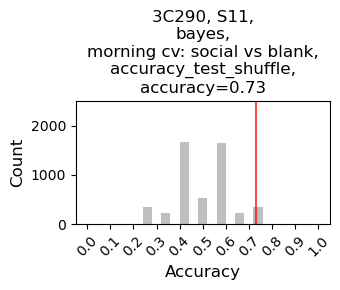

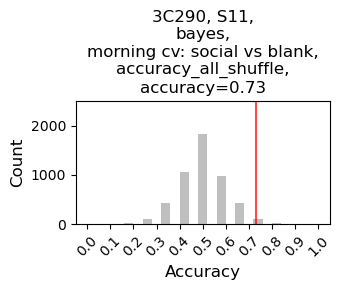

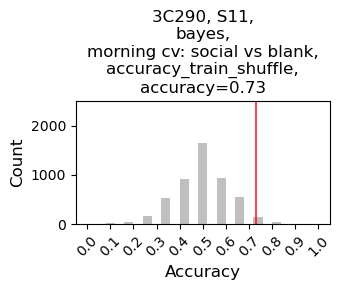

In [56]:
#plot data
for shuffle in ['accuracy_test_shuffle', 'accuracy_all_shuffle', 'accuracy_train_shuffle']:
    plt.figure(figsize=(3.5,3)) 
    bin_edges = np.arange(0, 1+0.04, 0.04)
    plt.hist(bayes_results[shuffle], bins=bin_edges, alpha=0.5, color='#808080')
    plt.axvline(bayes_results['accuracy'],color='red', alpha=0.7)
    a=bayes_results['accuracy']
    plt.title(f'{mouse}, S{Session},\nbayes,\nmorning cv: social vs blank,\n{shuffle},\naccuracy={a:.2f}')
    plt.xticks(rotation=45)
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.ylim(0,2500)
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\{mouse}_S{Session}_bayes_social_blank_{shuffle}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [63]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\models\\{mouse}_S{Session}_classifiers_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(classifiers_results, f)

In [65]:
print(f'Session {Session}')
for cv in ['evening_cv','day_cv','morning_cv', 'social_blank']:
    print(cv)
    print()
    for model in ['linear', 'poly', 'rbf', 'bayes']:

        print(model)
        print(round(classifiers_results[cv][model]['accuracy'], 3))
        print()
        print(round(classifiers_results[cv][model]['pval_all_shuffle'], 3))
        print(round(classifiers_results[cv][model]['pval_train_shuffle'], 3))
        print(round(classifiers_results[cv][model]['pval_test_shuffle'], 3))
        print()
    print('---------------------------------------')
    print()

Session 10
evening_cv

linear
0.5

0.515
0.496
0.499

poly
0.5

0.493
0.496
0.499

rbf
0.5

0.509
0.506
0.499

bayes
0.5

0.507
0.503
0.499

---------------------------------------

day_cv

linear
0.811

0.004
0.009
0.002

poly
0.767

0.011
0.024
0.016

rbf
0.778

0.009
0.025
0.009

bayes
0.744

0.006
0.007
0.007

---------------------------------------

morning_cv

linear
0.833

0.01
0.013
0.013

poly
0.833

0.019
0.106
0.012

rbf
0.883

0.003
0.064
0.006

bayes
0.633

0.097
0.079
0.123

---------------------------------------

social_blank

linear
0.983

0.0
0.001
0.001

poly
0.983

0.0
0.019
0.001

rbf
0.983

0.0
0.216
0.0

bayes
0.95

0.0
0.013
0.001

---------------------------------------



In [228]:
# # load
# with open(save_path, 'rb') as f:
#     classifiers_results = pickle.load(f)
# classifiers_results